# Behavior analysis
This analysis covers the foraging task in the physical setup. More information about that task can be found in the `TreadmillTracker` [repository](https://github.com/ckemere/TreadmillTracker).

Planned outline: develop each analysis for single session, then add batch feature
- Basic analysis: run as single session or batch mode
    - Harvest rate
    - Residence and travel time
    - Lick stats
- Patch dynamics: run as single session or batch mode
    - Reward rate vs. time in patch
    - Lick rate vs. time in patch
- Other analysis...

## Initial setup

### Imports

In [1]:
# Numerical tools
import numpy as np
import math

# Plotting tools
import matplotlib.pyplot as plt

# OS tools
from tempfile import TemporaryFile
import time

# Custom modules
import sys
sys.path.insert(0, '../python/')
import util
import session
import plot
import analysis

In [109]:
# Create Plotter object
plotter = plot.Plotter()

In [3]:
def save_figure(name, fmt='pdf'):
    with TemporaryFile(suffix='.{}'.format(fmt)) as f:
        plt.savefig(f, format=fmt)
        drive_service.upload(file_stream=f,
                             filename=name,
                             folder_ids=folder_id,
                             mime_type='application/octet-stream',
                             chunk_size=1024*256*4,
                             verbose=True)

## Single session analysis

### Load session

In [270]:
# Create Service object
drive_service = util.GoogleDriveService()

# Create results directory
folder_id = drive_service.get_folder_ids(foldername='R001', 
                                         exact_match=True, 
                                         parent='track_task_analysis')

# Load data file
data_filename = 'R001_d34_2019-09-11-1435_log.txt'
load_fn = lambda x: np.loadtxt(x, delimiter=',')
data = util.bytes_to_object(drive_service.download(filename=data_filename),
                            ob_type='numpy',
                            load_fn=load_fn)

# Load params file
params_filename = 'R001_d34_2019-09-11-1435_params.json'
params = util.bytes_to_object(drive_service.download(filename=params_filename),
                              ob_type='json')

# Create Session objects
sess = session.TTSession(data, params)

Exception ignored in: <ssl.SSLSocket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.85.51.25', 36562), raddr=('172.217.12.74', 443)>
Exception ignored in: <ssl.SSLSocket fd=57, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.85.51.25', 48492), raddr=('172.217.9.10', 443)>


### Session summary

In [271]:
T = sess.analyzed_time
t_patch = sess.get_patch_times()
#t_lick = analysis.get_lick_decisions(sess)
t_lick = sess.get_lick_times()
t_motor = sess.get_motor_times()

100% complete...
File sucessfully uploaded.


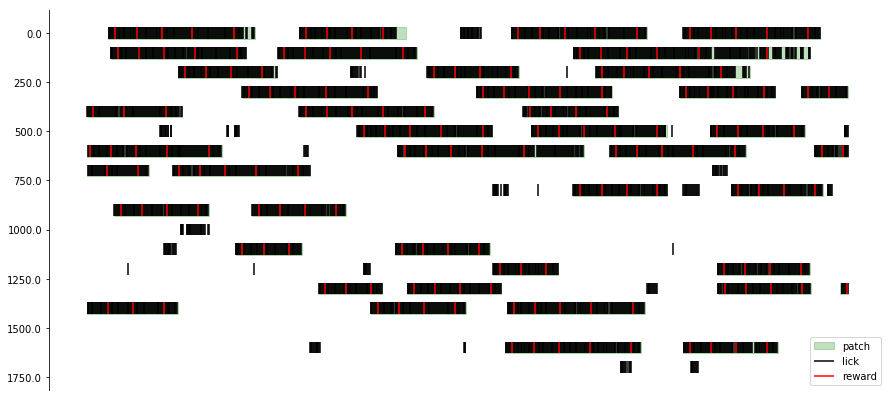

In [272]:
plotter.plot_session_summary(T=T,
                             t_patch=t_patch,
                             t_lick=t_lick,
                             t_motor=t_motor,
                             dt_chunk=100,
                             figsize=(15, 7))
save_figure('{:02d}_summary.png'.format(sess.day), fmt='png')

### Harvest rate

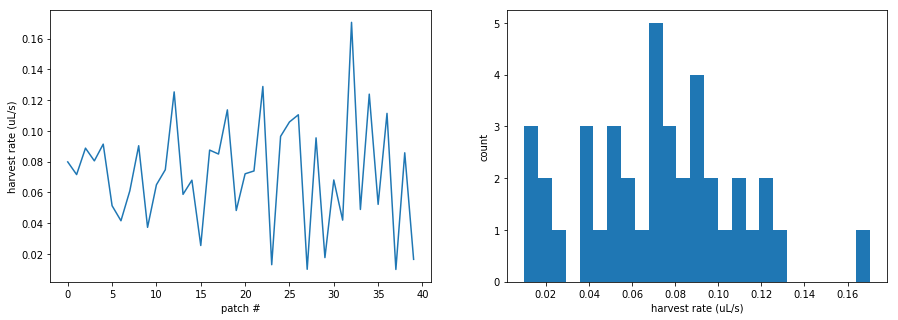

In [273]:
# Grab harvest rate over sessions
hr_obs = sess.get_harvest_rate(metric='observed', per_patch=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot harvest rate over patches
ax[0].plot(hr_obs)
ax[0].set_xlabel('patch #')
ax[0].set_ylabel('harvest rate (uL/s)')

# Plot distribution of harvest rates
ax[1].hist(hr_obs, bins=25)
ax[1].set_xlabel('harvest rate (uL/s)')
ax[1].set_ylabel('count');

### Residence and travel times

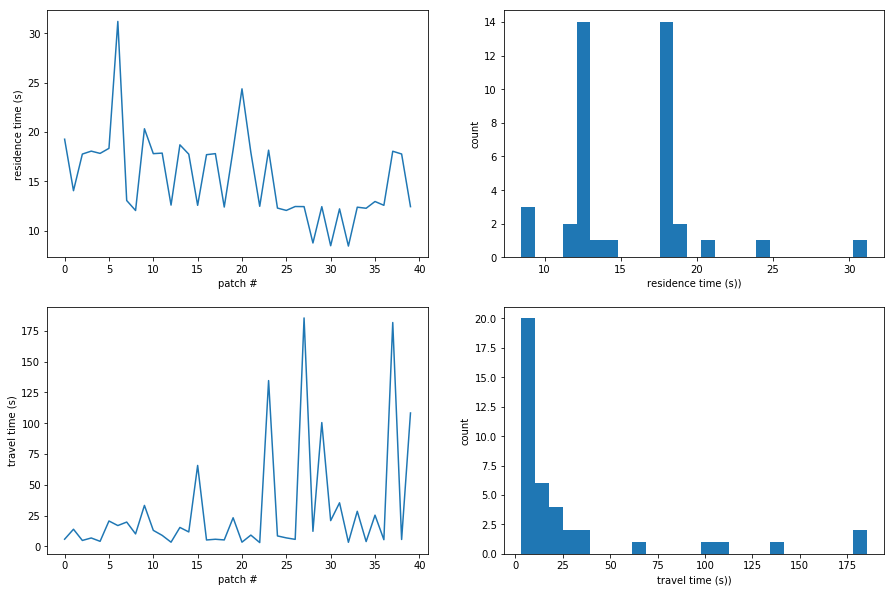

In [274]:
# Get residence and travel times
t_p_obs = sess.get_patch_durations()
t_t_obs = sess.get_interpatch_durations()

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot residence time over patches
ax[0, 0].plot(t_p_obs)
ax[0, 0].set_xlabel('patch #')
ax[0, 0].set_ylabel('residence time (s)')

# Plot distribution of residence times
ax[0, 1].hist(t_p_obs, bins=25)
ax[0, 1].set_xlabel('residence time (s))')
ax[0, 1].set_ylabel('count')

# Plot travel time over patches
ax[1, 0].plot(t_t_obs)
ax[1, 0].set_xlabel('patch #')
ax[1, 0].set_ylabel('travel time (s)')

# Plot distribution of travel times
ax[1, 1].hist(t_t_obs, bins=25)
ax[1, 1].set_xlabel('travel time (s))')
ax[1, 1].set_ylabel('count');

### Combined data

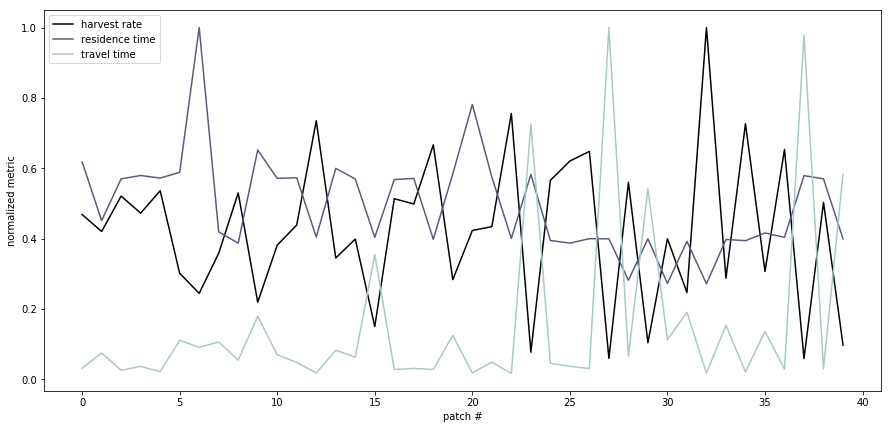

In [275]:
# Plot normalized harvest rate, residence time, and travel time per patch
fig, ax = plt.subplots(figsize=(15, 7))
cmap = plt.get_cmap('bone')

ax.plot(hr_obs/np.max(hr_obs), color=cmap(0.0), label='harvest rate')
ax.plot(t_p_obs/np.max(t_p_obs), color=cmap(0.4), label='residence time')
ax.plot(t_t_obs/np.max(t_t_obs), color=cmap(0.75), label='travel time')
ax.set_xlabel('patch #')
ax.set_ylabel('normalized metric')
ax.legend();

### Task engagement

#### By travel time

In [386]:
import scipy.stats as stats

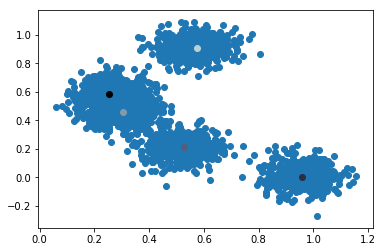

In [897]:
k = 5
X, mu, Sigma = [], [], []
for k_ in range(k):
    mu.append(np.random.rand(2))
    #Sigma_ = np.random.rand(2, 2)
    #Sigma.append((Sigma_.dot(Sigma_.T))**0.5) # random positive semi-definite matrix
    Sigma.append(0.005*np.eye(2))
    X.append(np.random.multivariate_normal(mean=mu[-1], cov=Sigma[-1], size=500))

X_all = np.vstack(X)
np.random.shuffle(X_all) # modifies in place

plt.scatter(X_all[:, 0], X_all[:, 1])
for k_ in range(k):
    plt.scatter(mu[k_][0], mu[k_][1], color=cmap(k_/k))

Fitting k-means model...
Converged after 12 iterations.
Fitting GM model...
Converged after 59 iterations.


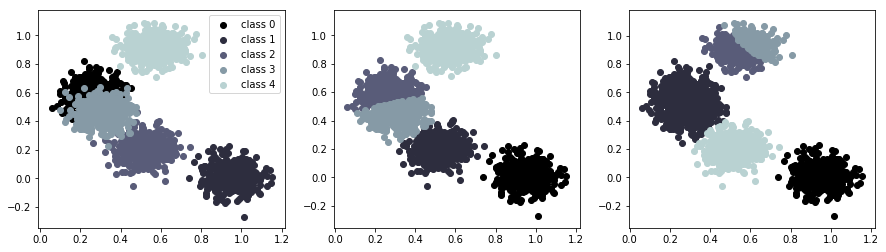

In [898]:
# Fit k-means model
print('Fitting k-means model...')
kmeans = KMeans(k)
kmeans.fit(X_all, init_method='random')
km_labels = kmeans.predict(X_all) # initial cluster labels

# Fit Gaussian-mixture model
print('Fitting GM model...')
gmm = GaussianMixture(k)
gmm.fit(X_all)
gmm_labels = gmm.predict(X_all)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for k_ in range(k):
    ax[0].scatter(X[k_][:, 0], X[k_][:, 1],
                  color=cmap(k_/k), label='class {}'.format(k_))
    ax[1].scatter(X_all[km_labels == k_, 0], X_all[km_labels == k_, 1], 
                  color=cmap(k_/k), label='class {}'.format(k_))
    ax[2].scatter(X_all[gmm_labels == k_, 0], X_all[gmm_labels == k_, 1], 
                  color=cmap(k_/k), label='class {}'.format(k_))

ax[0].legend();

In [ ]:
# Generate models
linear_normal = Gaussian()
linear_normal.fit(t_t_obs)
log_normal = LogGaussian()
log_normal.fit(t_t_obs)
poisson = Poisson(0)
poisson.fit(t_t_obs, interevent=True)

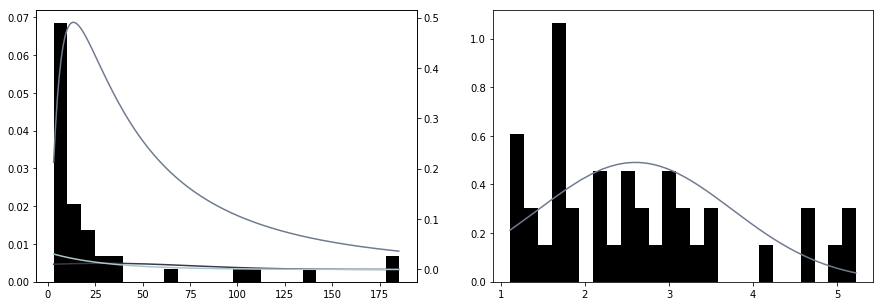

In [451]:
# Plot distribution of travel time
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
t = np.arange(np.min(t_t_obs), np.max(t_t_obs))

# Linear space
ax[0].hist(t_t_obs, bins=25, density=True, color=cmap(0.0))
ax2 = ax[0].twinx()
ax2.plot(t, linear_normal._pdf(t), color=cmap(0.25))
ax2.plot(t, log_normal._pdf(t), color=cmap(0.50))
ax2.plot(t, poisson._pdf(t), color=cmap(0.75))

# Log space
ax[1].hist(np.log(t_t_obs), bins=25, density=True, color=cmap(0.0))
ax[1].plot(np.log(t), log_normal._pdf(t), color=cmap(0.50))

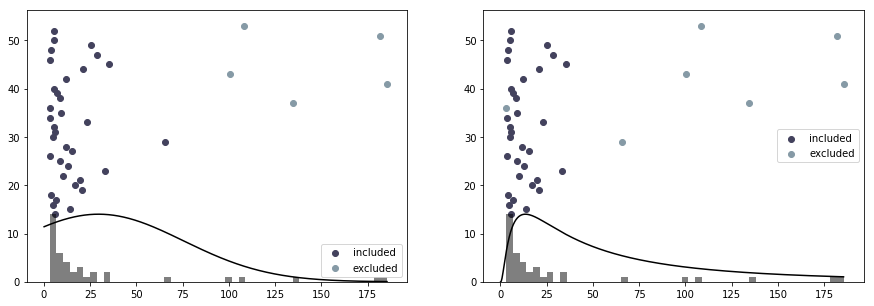

In [454]:
# Choose cutoffs
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
cmap = plt.get_cmap('bone')
tt = np.linspace(0.1, t_t_obs.max(), num=1000) # for pdf
thresh = 0.80 # percentile

# Iterate over models
for i, model in enumerate([linear_normal, log_normal]):
    # Get indices of included times
    idx = model.test_statistic(t_t_obs, 
                               distribution='f', 
                               test='<=', 
                               q=thresh)
    
    # Calculate distribution of times within model
    counts, bins, _ = ax[i].hist(t_t_obs, bins=50, 
                                 color=cmap(0.0), alpha=0.5)
    pdf = model.pdf(tt)
    
    # Plot distributions and results
    ax[i].plot(tt, pdf/pdf.max()*counts.max(), color=cmap(0.0))
    ax[i].scatter(t_t_obs[idx], np.arange(len(t_t_obs))[idx] + np.max(counts), 
                color=cmap(0.3), label='included')
    ax[i].scatter(t_t_obs[~idx], np.arange(len(t_t_obs))[~idx] + np.max(counts), 
                color=cmap(0.6), label='excluded')

    ax[i].legend()

## Batch analysis

### Load sessions

In [119]:
service = util.GoogleDriveService()

In [120]:
mouse_ids = ['R001', 'R002', 'R003', 'R004']
session_range = [1, 50]

In [121]:
sessions = {}
load_fn = lambda x: np.loadtxt(x, delimiter=',')
for mouse_id in mouse_ids:
    # Get parent folder ID
    parent_id = service.get_folder_ids(foldername=mouse_id,
                                       unique=True,
                                       exact_match=True,
                                       parent='track_data')[0]
    
    # Get param file IDs and filenames
    param_fids = service.get_file_ids(filename='.json',
                                      exact_match=False,
                                      parent=parent_id)
    param_filenames = service.get_file_metadata(file_ids=param_fids, fields='name')
    param_filenames = [f['name'] for f in param_filenames]
    
    # Find corresponding log file IDs
    suffix = '_params.json'
    log_filenames = [f[:-len(suffix)] + '_log.txt' for f in param_filenames]
    log_fids = []
    for log_filename in log_filenames:
        log_fids.append(service.get_file_ids(filename=log_filename,
                                             exact_match=True,
                                             parent=parent_id)[0])

    # Load param and data files in session range
    sessions[mouse_id] = []
    print('Downloading sessions for mouse %s:' % mouse_id)
    for param_fid, log_fid in zip(param_fids, log_fids):
        params = util.bytes_to_object(service.download(file_id=param_fid), ob_type='json')
        session_id = params['Info'].get('Session', 0)
        if (session_id >= session_range[0]) and (session_id <= session_range[1]):
            print('Downloading session %d...' % session_id, end=' ')
            log = util.bytes_to_object(service.download(file_id=log_fid),
                                       ob_type='numpy', 
                                       load_fn=load_fn)
            sessions[mouse_id].append(session.TTSession(log, params))
            print('done.')
   
    print()

In [122]:
# Get days for faster downstream processing
days = {}
for mouse_id in mouse_ids:
    days[mouse_id] = [sess.day for sess in sessions[mouse_id]]

In [123]:
cache = {}
for mouse_id in mouse_ids:
    cache[mouse_id] = []
    for sess in sessions[mouse_id]:
        cache[mouse_id].append((sess.raw_data, sess.params))

### Harvest rate

In [191]:
importlib.reload(util)
importlib.reload(plot)
importlib.reload(session)
plotter = plot.Plotter()

In [520]:
sessions = {}
for mouse_id in mouse_ids:
    sessions[mouse_id] = []
    for (data, params) in cache[mouse_id]:
        sessions[mouse_id].append(session.TTSession(data, params))

In [522]:
# Grab harvest rate over sessions
hr_obs = {} # observed rate
hr_max = {} # maximum rate given leaving decisions
hr_opt = {} # optimal rate (MVT) given environment
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)

    # Placeholders
    hr_obs[mouse_id] = []
    hr_max[mouse_id] = []
    hr_opt[mouse_id] = []

    for sess in sessions[mouse_id]:
        print('Processing session %d...' % sess.day, end=' ')
        try:
            hr_obs[mouse_id].append(sess.get_harvest_rate(metric='observed', per_patch=True))
            #hr_max[mouse_id].append(sess.get_harvest_rate(metric='max', per_patch=True))
            #hr_opt[mouse_id].append(sess.get_harvest_rate(metric='optimal', per_patch=True))
            print('done.')
        except IndexError as w: # unanalyzable session
            print(w)
            hr_obs[mouse_id].append(np.array([np.nan]))
            #hr_max[mouse_id].append(np.array([np.nan]))
            #hr_opt[mouse_id].append(np.array([np.nan]))

    print()    

Analyzing mouse R001:
Processing session 1... done.
Processing session 2... index 0 is out of bounds for axis 0 with size 0
Processing session 3... done.
Processing session 4... done.
Processing session 5... done.
Processing session 6... done.
Processing session 7... done.
Processing session 8... done.
Processing session 9... done.
Processing session 10... done.
Processing session 11... done.
Processing session 12... done.
Processing session 13... done.
Processing session 14... done.
Processing session 15... done.
Processing session 16... done.
Processing session 17... done.
Processing session 18... done.
Processing session 19... done.
Processing session 20... done.
Processing session 21... done.
Processing session 22... done.
Processing session 23... done.
Processing session 24... index 0 is out of bounds for axis 0 with size 0
Processing session 25... done.
Processing session 26... done.
Processing session 27... done.
Processing session 28... done.
Processing session 29... done.
Proc

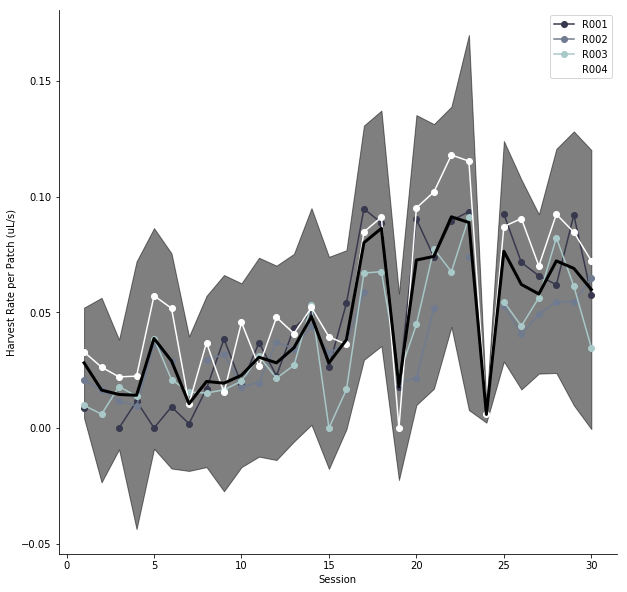

In [523]:
plotter.set_cmap('bone')
plotter.plot_harvest_rates(days, hr_obs, plot_traces=True, err='std', err_plot='fill', c=0.0)
plt.legend();

### Residence and travel time

In [524]:
# Grab patch residence and travel times
t_p_obs = {}
t_p_opt = {}
t_t_obs = {}
t_t_opt = {}
for mouse_id in mouse_ids:
    print('Analyzing mouse %s:' % mouse_id)

    # Placeholders
    t_p_obs[mouse_id] = []
    t_p_opt[mouse_id] = []
    t_t_obs[mouse_id] = []
    t_t_opt[mouse_id] = []

    for sess, day in zip(sessions[mouse_id], days[mouse_id]):
        print('Processing session %d... ' % day, end=' ')

        try:
            t_p_obs[mouse_id].append(sess.get_patch_durations())
            t_t_obs[mouse_id].append(sess.get_interpatch_durations())   
        except (UserWarning, IndexError) as w: # unanalyzable session
            print(w)
            t_p_obs[mouse_id].append(np.asarray([np.nan]))
            t_t_obs[mouse_id].append(np.asarray([np.nan]))
            
        try:
            _, _, t_p_opt_, t_t_opt_ = sess.get_harvest_rate(metric='optimal', return_all=True)
            t_p_opt[mouse_id].append(np.asarray([t_p_opt_]))
            t_t_opt[mouse_id].append(np.asarray([t_t_opt_]))
            print('done.')
        except (UserWarning, IndexError) as w: # no reward decay params or unanalyzable session
            print(w)
            t_p_opt[mouse_id].append(np.asarray([np.nan]))
            t_t_opt[mouse_id].append(np.asarray([np.nan]))

    print()

Analyzing mouse R001:
Processing session 1...  Reward depletion parameters not specified.
Processing session 2...  index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
Processing session 3...  Reward depletion parameters not specified.
Processing session 4...  Reward depletion parameters not specified.
Processing session 5...  Reward depletion parameters not specified.
Processing session 6...  Reward depletion parameters not specified.
Processing session 7...  Reward depletion parameters not specified.
Processing session 8...  Reward depletion parameters not specified.
Processing session 9...  Reward depletion parameters not specified.
Processing session 10...  Reward depletion parameters not specified.
Processing session 11...  Reward depletion parameters not specified.
Processing session 12...  Reward depletion parameters not specified.
Processing session 13...  Reward depletion parameters not specified.
Processing session 14...  Reward depl

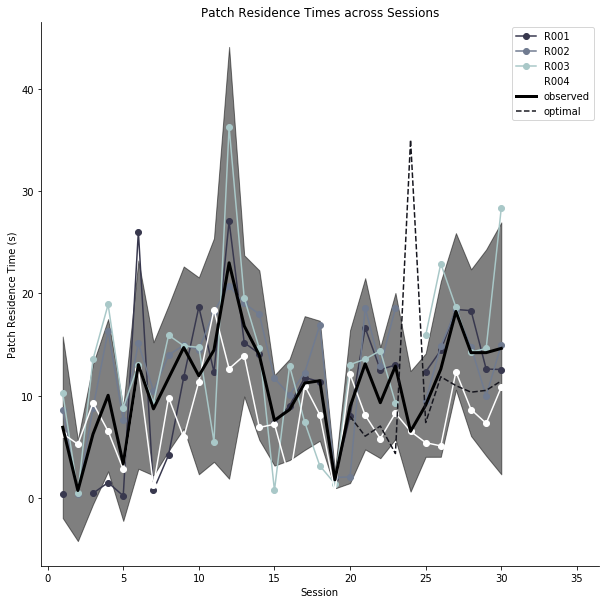

In [525]:
plotter.set_cmap('bone')
plotter.plot_residence_times(days, t_p_obs, t_p_opt, plot_traces=True, err='std', err_plot='fill', c=0.0)

In [526]:
# Get decay rate of each session
tau = {}
for mouse_id in mouse_ids:
    tau[mouse_id] = []
    for sess in sessions[mouse_id]:
         # Get tau if available
        try:
            tau[mouse_id].append(sess.params['Reward']['tau'])
        except KeyError:
            tau[mouse_id].append(-1)  

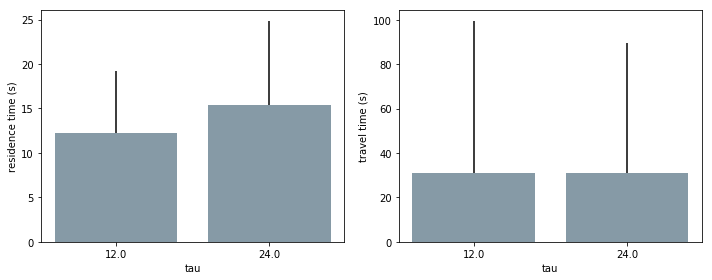

In [527]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('bone')

# Collect patch data by decay rate
t_p_plot, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
t_p_err, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot residence times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_p_err[plot_idx]])
ax[0].bar(np.arange(len(plot_idx)), 
          t_p_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[0].set_xticks(np.arange(len(plot_idx)))
ax[0].set_xticklabels(tau_plot[plot_idx])
ax[0].set_xlabel('tau')
ax[0].set_ylabel('residence time (s)')

# Collect patch data by decay rate
t_t_plot, tau_plot = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
t_t_err, tau_plot = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot travel times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_t_err[plot_idx]])
ax[1].bar(np.arange(len(plot_idx)), 
          t_t_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[1].set_xticks(np.arange(len(plot_idx)))
ax[1].set_xticklabels(tau_plot[plot_idx])
ax[1].set_xlabel('tau')
ax[1].set_ylabel('travel time (s)')

plt.tight_layout();

In [528]:
t_p_plot, tau_plot = util.get_patch_statistics(t_p_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)

<BarContainer object of 2 artists>

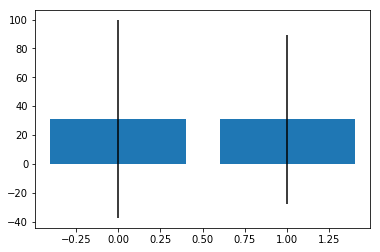

In [529]:
# Collect travel time data by decay rate
data, tau_ = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='mean', 
                                    return_all=False)
err, tau_ = util.get_patch_statistics(t_t_obs, 
                                    ids=tau, 
                                    method='std', 
                                    return_all=False)

# Plot results
plot_idx = np.argwhere(tau_ > 0.0).flatten()
plt.bar(np.arange(len(plot_idx)), data[plot_idx], yerr=err[plot_idx])

### Inclusion criteria
Filter residence and travel times based on inclusion criteria.

In [604]:
data, tau_ = util.get_patch_statistics(t_t_obs['R002'],
                                       ids=tau['R002'],
                                       method='mean',
                                       return_all=True)

In [633]:
# For each set of conditions, create a new model distribution
linear_normal = {}
log_normal = {}
exp = {}
for tau_i in np.unique(tau_):
    print('Tau = {:2f}'.format(tau_i))
    
    # Find indices
    idx = np.argwhere(tau_ == tau_i).flatten()
    
    # Fit linear normal model
    linear_normal[tau_i] = Gaussian()
    linear_normal[tau_i].fit(data[idx])
    mu = linear_normal[tau_i].params['mu']
    std = linear_normal[tau_i].params['sigma']
    p = linear_normal[tau_i].goodness_of_fit(data[idx], method='SW').pvalue
    print('Linear-normal: mu={:2f}, std={:2f}, p={:5e}'.format(mu, std, p))
    
    # Fit log normal model
    log_normal[tau_i] = LogGaussian()
    log_normal[tau_i].fit(data[idx])
    mu = log_normal[tau_i].params['mu']
    std = log_normal[tau_i].params['sigma']
    p = log_normal[tau_i].goodness_of_fit(data[idx], method='SW').pvalue
    print('Log-normal: mu={:2f}, std={:2f}, p={:5e}'.format(mu, std, p))
    
    # Fit exponential model
    exp[tau_i] = Exponential()
    exp[tau_i].fit(data[idx])
    lam = exp[tau_i].params['lam']
    p = exp[tau_i].goodness_of_fit(data[idx]).pvalue
    print('Exponential: lambda={:2f}, p={:5e}'.format(lam, p))
    
    print()

Tau = -1.000000
Linear-normal: mu=73.904258, std=91.693247, p=4.716501e-24
Log-normal: mu=3.692841, std=1.135074, p=2.056079e-02
Exponential: lambda=0.013531, p=4.238485e-05

Tau = 12.000000
Linear-normal: mu=40.983765, std=66.716109, p=2.023363e-20
Log-normal: mu=3.087899, std=1.005358, p=3.049026e-05
Exponential: lambda=0.024400, p=5.017696e-05

Tau = 24.000000
Linear-normal: mu=33.507548, std=46.831938, p=6.654281e-22
Log-normal: mu=3.069262, std=0.859991, p=2.831188e-04
Exponential: lambda=0.029844, p=1.038065e-03



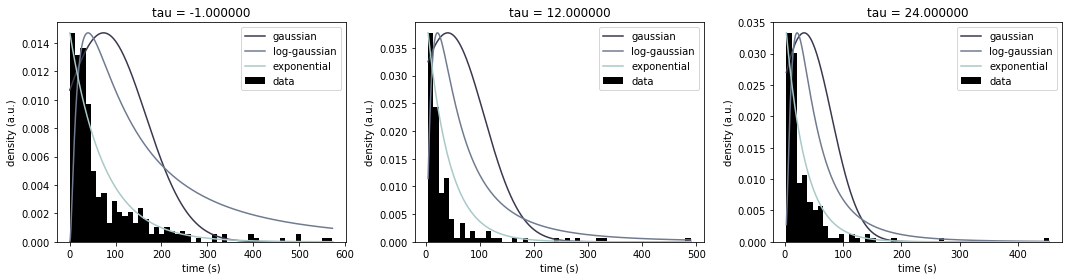

In [637]:
# Plot fits
nplots = len(np.unique(tau_))
ncols = 3
nrows = nplots // ncols + (nplots % ncols > 0)
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
for i, tau_i in enumerate(np.unique(tau_)):
    # Find indices
    idx = np.argwhere(tau_ == tau_i).flatten()
    
    # Plot histogram
    j = i // ncols
    k = i % ncols
    if nrows == 1:
        ax_ = ax[k]
    else:
        ax_ = ax[j, k]
    vals, bins, _ = ax_.hist(data[idx], 
                             bins=50,
                             color=cmap(0.0), 
                             density=True,
                             label='data')
    
    # Plot model fits
    t = np.linspace(data[idx].min(), data[idx].max(), 1000)
    for j, model in enumerate([linear_normal[tau_i], log_normal[tau_i], exp[tau_i]]):
        pdf = model.pdf(t)
        scale = vals.max()/pdf.max()
        ax_.plot(t, scale*pdf,
                 color=cmap(0.25*(j+1)),
                 label=model.name)
        
    # Format plot
    ax_.set_title('tau = {:2f}'.format(tau_i))
    ax_.set_ylabel('density (a.u.)')
    ax_.set_xlabel('time (s)')
    ax_.legend()
    
plt.tight_layout()

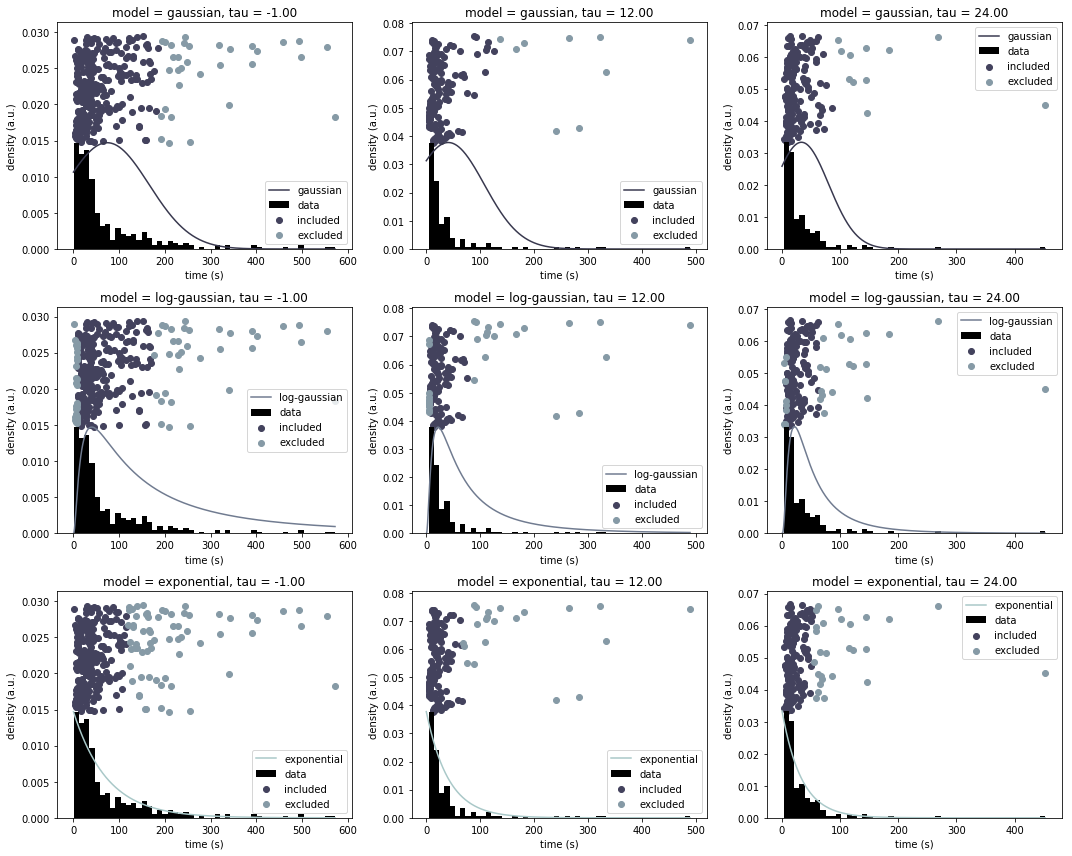

In [650]:
# Choose cutoffs
ncols = len(np.unique(tau_))
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
thresh = 0.80 # percentile

# Iterate over models
for i, tau_i in enumerate(np.unique(tau_)):
    # Find indices
    idx = np.argwhere(tau_ == tau_i).flatten()
    t = np.linspace(0.1, data[idx].max(), num=1000) # for pdf
    
    for j, model in enumerate([linear_normal[tau_i], log_normal[tau_i], exp[tau_i]]):
        # Plot histogram
        ax_ = ax[j, i]
        vals, bins, _ = ax_.hist(data[idx], 
                                 bins=50,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')
        
        # Get indices of included times
        method = getattr(model, 'test_statistic', None)
        if method is not None and callable(method):
            idx_include = model.test_statistic(data[idx], 
                                               distribution='f', 
                                               test='<=', 
                                               q=thresh)
        else:
            idx_include = (data[idx] <= model._inv_cdf(thresh))

        # Plot pdf
        pdf = model.pdf(t)
        scale = vals.max()/pdf.max()
        ax_.plot(t, scale*pdf,
                 color=cmap(0.25*(j+1)),
                 label=model.name)

        # Plot data points
        x = np.linspace(vals.max(), 2*vals.max(), num=len(data[idx]))
        ax_.scatter(data[idx][idx_include], 
                    x[idx_include], 
                    color=cmap(0.3), 
                    label='included')
        ax_.scatter(data[idx][~idx_include], 
                    x[~idx_include], 
                    color=cmap(0.6), 
                    label='excluded')

        # Format plot
        ax_.set_title('model = {}, tau = {:.2f}'.format(model.name, tau_i))
        ax_.set_ylabel('density (a.u.)')
        ax_.set_xlabel('time (s)')
        ax_.legend()
        
plt.tight_layout()

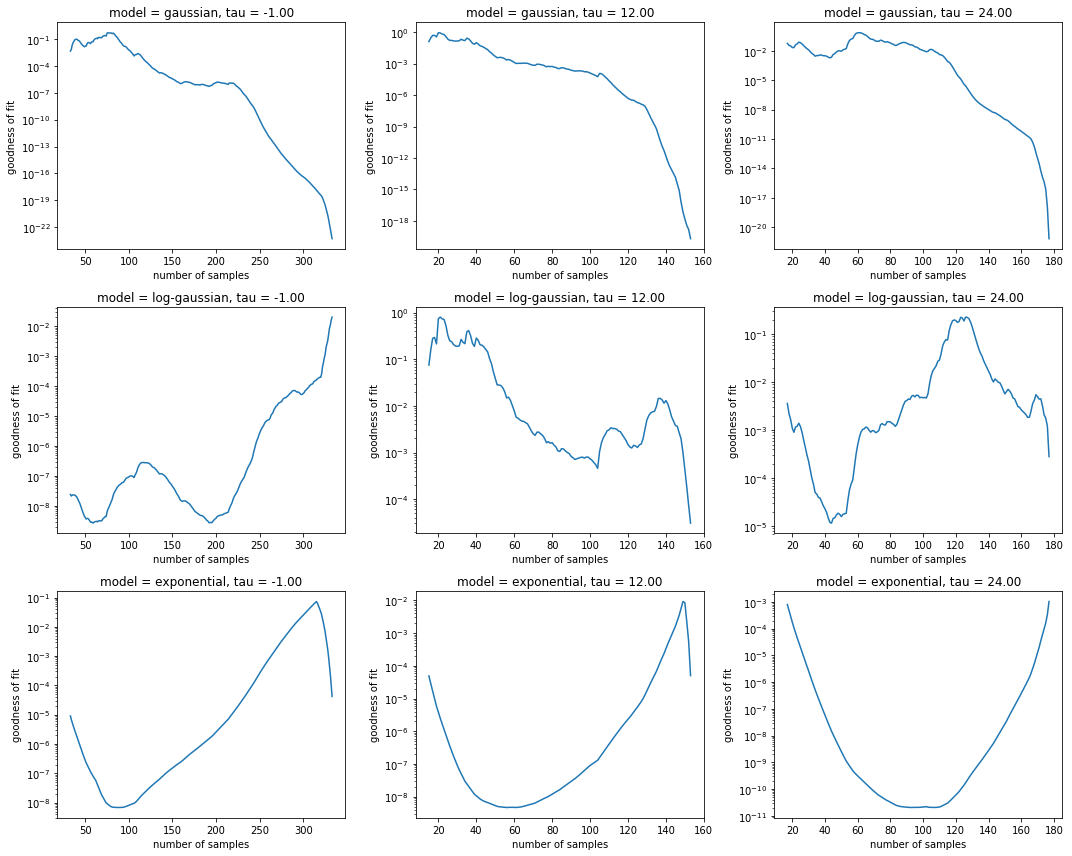

In [686]:
# Next idea: drop travel times until a best match for a normal distribution is found
ncols = len(np.unique(tau_))
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
opt_samples = {}

# Iterate over models
for i, tau_i in enumerate(np.unique(tau_)):
    # Find indices
    idx = np.argwhere(tau_ == tau_i).flatten()
    data_i = np.sort(data[idx])
    
    # Placeholder
    opt_samples[tau_i] = {}
    
    for j, Model in enumerate([Gaussian, LogGaussian, Exponential]):
        model = Model()
        n_range = np.arange(int(0.10*len(data_i)), len(data_i)+1)
        p = np.zeros([len(n_range)])
        for k, n in enumerate(n_range):
            model.fit(data_i[:n])
            p[k] = model.goodness_of_fit(data_i[:n]).pvalue
        
        # Plot p-values vs. number of samples
        ax_ = ax[j, i]
        ax_.plot(n_range, p)
        
        # Save argmax
        opt_samples[tau_i][model.name] = n_range[np.argmax(p)]
        
        # Format plot
        ax_.set_title('model = {}, tau = {:.2f}'.format(model.name, tau_i))
        ax_.set_ylabel('goodness of fit')
        ax_.set_xlabel('number of samples')
        ax_.set_yscale('log')
        #ax_.legend()     
        
plt.tight_layout()

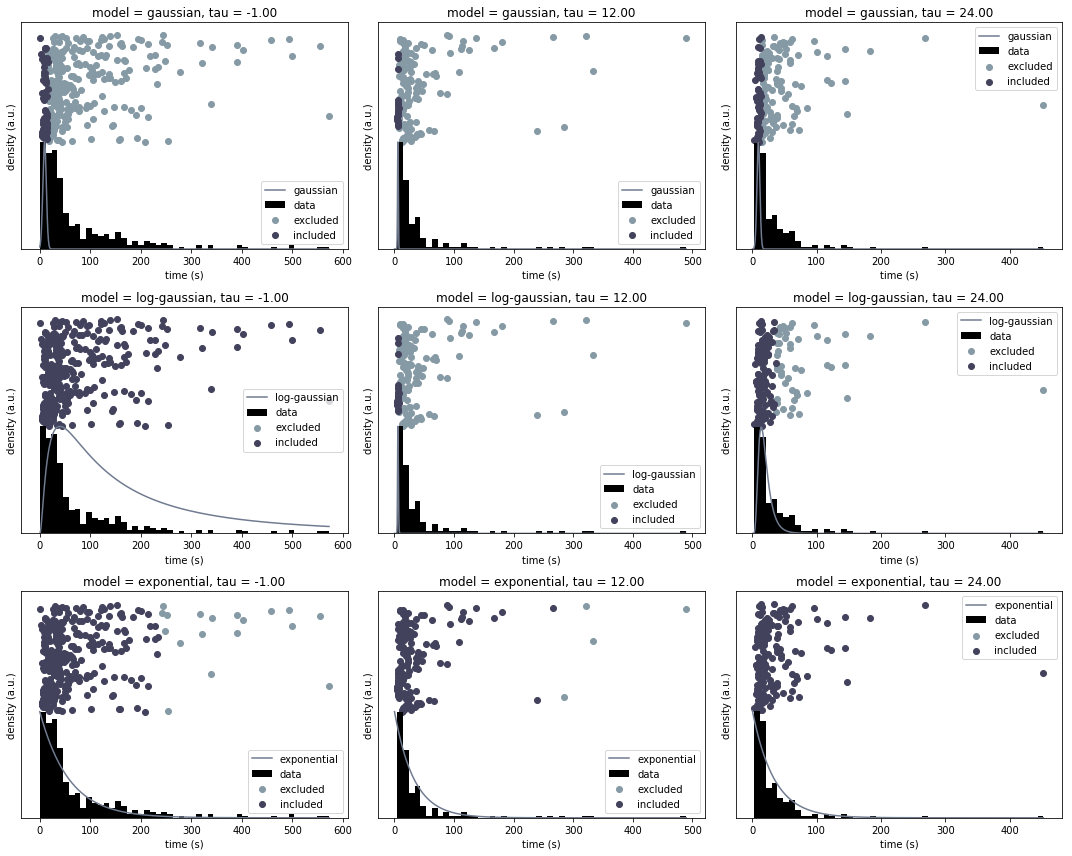

In [950]:
# Choose cutoffs by maximizing goodness of fit via above
ncols = len(np.unique(tau_))
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Iterate over models
for i, tau_i in enumerate(np.unique(tau_)):
    # Find indices
    idx = np.argwhere(tau_ == tau_i).flatten()
    t = np.linspace(0.1, data[idx].max(), num=1000) # for pdf
    
    for j, Model in enumerate([Gaussian, LogGaussian, Exponential]):
        # Plot histogram
        ax_ = ax[j, i]
        vals, bins, _ = ax_.hist(data[idx], 
                                 bins=50,
                                 color=cmap(0.0), 
                                 density=True,
                                 label='data')
        
        # Get indices of included times
        model = Model()
        n_samples = opt_samples[tau_i][model.name]
        model.fit(np.sort(data[idx])[:n_samples])
        idx_include = np.zeros(len(idx), dtype=np.bool)
        idx_include[np.argsort(data[idx])[:n_samples]] = True
        
        # Plot pdf
        pdf = model.pdf(t)
        scale = vals.max()/pdf.max()
        ax_.plot(t, scale*pdf,
                 color=cmap(0.50),
                 label=model.name)

        # Plot data points
        x = np.linspace(vals.max(), 2*vals.max(), num=len(data[idx]))
        ax_.scatter(data[idx][~idx_include], 
                    x[~idx_include], 
                    color=cmap(0.6), 
                    label='excluded')
        ax_.scatter(data[idx][idx_include], 
                    x[idx_include], 
                    color=cmap(0.3), 
                    label='included')

        # Format plot
        ax_.set_title('model = {}, tau = {:.2f}'.format(model.name, tau_i))
        ax_.set_ylabel('density (a.u.)')
        ax_.set_yticks([])
        ax_.set_xlabel('time (s)')
        #ax_.set_xlim([-10, 200])
        ax_.legend()
        
plt.tight_layout()

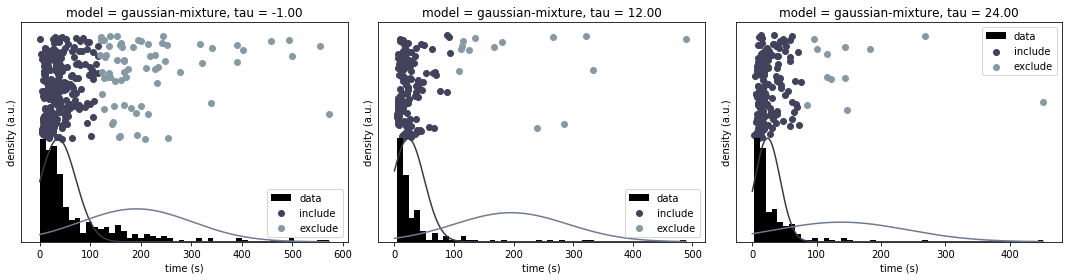

In [947]:
# Choose cutoffs by fitting to GMM with k=2
k = 2
ncols = len(np.unique(tau_))
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))

# Iterate over models
gmm = {}
for i, tau_i in enumerate(np.unique(tau_)):
    # Find indices
    idx = np.argwhere(tau_ == tau_i).flatten()
    t = np.linspace(0.1, data[idx].max(), num=1000) # for pdf
    
    # Plot histogram
    ax_ = ax[i]
    vals, bins, _ = ax_.hist(data[idx], 
                             bins=50,
                             color=cmap(0.0), 
                             density=True,
                             label='data')

    # Get fit GMM
    model = GaussianMixture(k=k)
    model.fit(data[idx], verbose=False)
    labels = model.predict(data[idx])
    gmm[tau_i] = model

    # Plot pdf
    max_val = 0.0
    scale = 1.0
    for k_ in range(k):
        pdf = model._models[k_].pdf(t)
        if pdf.max() > max_val:
            scale = vals.max()/pdf.max()
            max_val = pdf.max()
    for k_ in range(k):  
        pdf = model._models[k_].pdf(t)
        ax_.plot(t, scale*pdf,
                 color=cmap(0.25*(k_+1)))
        
    # Plot data points
    x = np.linspace(vals.max(), 2*vals.max(), num=len(data[idx]))
    label_include = np.argmin(model.params['mu'])
    idx_include = (labels == label_include)
    ax_.scatter(data[idx][idx_include], 
                x[idx_include], 
                color=cmap(0.30),
                label='include')
    ax_.scatter(data[idx][~idx_include], 
                x[~idx_include], 
                color=cmap(0.60),
                label='exclude')

    # Format plot
    ax_.set_title('model = {}, tau = {:.2f}'.format(model.name, tau_i))
    ax_.set_ylabel('density (a.u.)')
    ax_.set_yticks([])
    ax_.set_xlabel('time (s)')
    #ax_.set_xlim([-10, 200])
    ax_.legend()
        
plt.tight_layout()

Now let's re-plot the travel time and residence time results with filtered data. From the above plot, it looks like fitting a GMM with two components gives reasonable results.

Remember that the underlying code in `Session.get_patch_durations()` and `Session.get_interpatch_durations()` already pairs each residence time with the subsequent travel time (with the idea that residence time is informed by the anticipated subsequent travel time). Thus if we filter by travel times, we can simply use the same indices to filter the residence times, knowing that they will be matched.

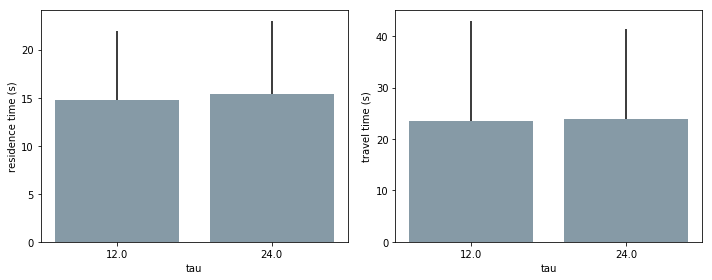

In [945]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('bone')

# Filter data by inclusion criteria
t_p_filt = {}
t_t_filt = {}
tau_filt = {}
for mouse_id in ['R002']:
    # Get data
    t_t_, tau_1 = util.get_patch_statistics(t_t_obs[mouse_id],
                                           ids=tau[mouse_id],
                                           return_all=True)
    t_p_, tau_2 = util.get_patch_statistics(t_p_obs[mouse_id],
                                           ids=tau[mouse_id],
                                           return_all=True)
    assert (tau_1 == tau_2).all()
    tau_ = tau_1
    
    # Iterate over models
    t_t_filt_ = []
    t_p_filt_ = []
    tau_filt_ = []
    for i, tau_i in enumerate(np.unique(tau_)):
        # Find indices
        idx = np.argwhere(tau_ == tau_i).flatten()
        
        # Get inclusion labels
        labels = gmm[tau_i].predict(t_t_[idx])
        label_include = np.argmin(gmm[tau_i].params['mu'])
        idx_include = (labels == label_include)
        
        # Keep only included data
        t_t_filt_.append(t_t_[idx][idx_include])
        t_p_filt_.append(t_p_[idx][idx_include])
        tau_filt_.append(tau_[idx][idx_include])
        
    # Stack data
    t_t_filt[mouse_id] = np.hstack(t_t_filt_)
    t_p_filt[mouse_id] = np.hstack(t_p_filt_)
    tau_filt[mouse_id] = np.hstack(tau_filt_)

# Collect patch data by decay rate
t_p_plot, tau_plot = util.get_patch_statistics(t_p_filt, 
                                    ids=tau_filt, 
                                    method='mean', 
                                    return_all=False)
t_p_err, tau_plot = util.get_patch_statistics(t_p_filt, 
                                    ids=tau_filt, 
                                    method='std', 
                                    return_all=False)

# Plot residence times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_p_err[plot_idx]])
ax[0].bar(np.arange(len(plot_idx)), 
          t_p_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[0].set_xticks(np.arange(len(plot_idx)))
ax[0].set_xticklabels(tau_plot[plot_idx])
ax[0].set_xlabel('tau')
ax[0].set_ylabel('residence time (s)')

# Collect patch data by decay rate
t_t_plot, tau_plot = util.get_patch_statistics(t_t_filt, 
                                    ids=tau_filt, 
                                    method='mean', 
                                    return_all=False)
t_t_err, tau_plot = util.get_patch_statistics(t_t_filt, 
                                    ids=tau_filt, 
                                    method='std', 
                                    return_all=False)

# Plot travel times
plot_idx = np.argwhere(tau_plot > 0.0).flatten()
yerr = np.vstack([np.zeros(len(plot_idx)), t_t_err[plot_idx]])
ax[1].bar(np.arange(len(plot_idx)), 
          t_t_plot[plot_idx], 
          yerr=yerr,
          color=cmap(0.60))
ax[1].set_xticks(np.arange(len(plot_idx)))
ax[1].set_xticklabels(tau_plot[plot_idx])
ax[1].set_xlabel('tau')
ax[1].set_ylabel('travel time (s)')

plt.tight_layout();

In [ ]:
# Next, compare experimental conditions with barrier vs. non-barrier,
# and different values of tau.

## Development

### Helper functions

In [ ]:
def save_sessions(mouse_id):
    print('Saving sessions for mouse %s...' % mouse_id)
    mouse_dir = sess_dir + mouse_id + '/'
    if not os.path.isdir(mouse_dir):
        os.mkdir(mouse_dir)
    for sess, day in zip(sessions[mouse_id], days[mouse_id]):
        sess.save(mouse_dir + '%02d.p' % day)

In [177]:
# To-Do
# - Run all behavior in a single notebook. Only settings at top should be different, based on LV vs TT.
# - Create criteria for task engagement. Maybe a one-sided distribution of harvest rate, with some
#   cutoff threshold? (log-normal distribution?) The harvest rate could be per unit time or patch-interpatch segment

### Multivariate Gaussian CDF
https://upload.wikimedia.org/wikipedia/commons/a/a2/Cumulative_function_n_dimensional_Gaussians_12.2013.pdf

In [493]:
def cdf(m, r):
    if m == 1:
        return 2*(stats.norm.cdf(r, loc=0, scale=1) - 0.5)
    elif m == 2:
        return 1.0 - np.exp(-0.5*r**2)
    else:
        return cdf(m-2, r) - r**(m-2)*np.exp(-0.5*r**2)/(m-2)

In [494]:
cdf(5,2)

0.32293508099944895

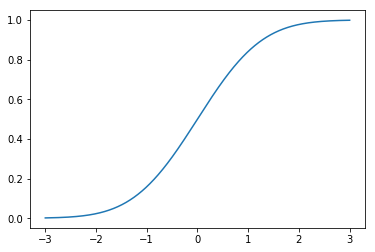

In [496]:
t = np.linspace(-3, 3, 1000)
plt.plot(t, stats.norm.cdf(t))